# Imports

In [1]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Experiment settings
Settings are based on the training procedure that produced the final generator used in evaluating the stylized facts and training the RL agent in portfolio management.  
However, using different machines would result in cumulative differences in computation results likely due to varied machine precision.  
Original experiments were performed on machine with following specs:
1. OS: Ubuntu 20.04.1
2. CPU: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
3. GPU: Tesla V100-SXM2-32GB

### Dataset related

In [2]:
# samples
batch_size = 38 # number of samples in each batch
sample_len = 300 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = True # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42

# real data parameters
stride = 50 # for real data
start_date = '1995-01-01' # start date for real data
end_date = '2018-09-18' # end date for real data

### Generator and kernel related

In [3]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 10 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = True # feed in history for LSTM generators
hist_len = 50

### Noise related

In [4]:
noise_dim = 4 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 20

### Training Related

In [5]:
epochs = 10000 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.1 # starting kernel_sigma
num_losses = 20

### Save to tensorboard log

In [6]:
# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)

### Data, kernel, generator

In [7]:
dataloader = get_dataloader(**{**data_params, **model_params})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5855.988337142852
            Iterations: 37
            Function evaluations: 859
            Gradient evaluations: 37
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5855.99
Distribution:                  Normal   AIC:                           11754.0
Method:            Maximum Likelihood   BIC:                           11897.9
                                        No. Observations:                 6999
Date:                Mon, Sep 02 2024   Df Residuals:                     6999
Time:                        09:50:35   Df Model:                            0
                               Volatility Model                              
 

GenLSTM(
  (rnn): LSTM(6, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

2
torch.Size([38, 300, 2])
torch.Size([38, 299, 4])


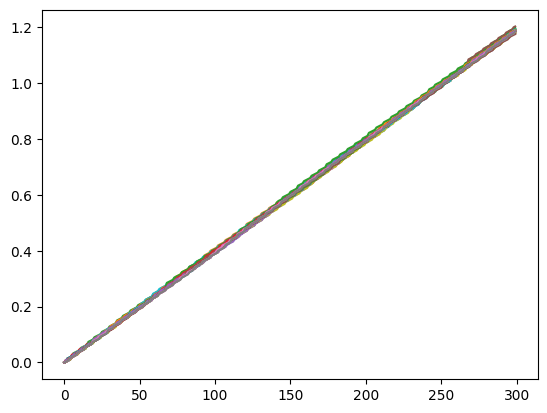

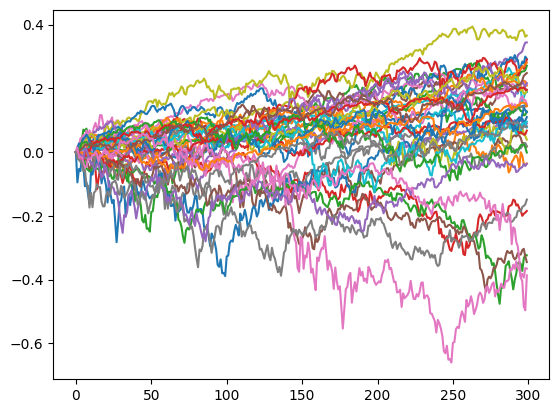

In [8]:
# Visualize data
for item in dataloader:
    print(len(item))
    print(item[0].shape)
    print(item[1].shape)
    break
plt.plot(item[0][:,:,0].T)
plt.show()
plt.plot(item[0][:,:,1].T)
plt.show()

# Train MMD-GAN

In [9]:
# train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

In [10]:
dict = torch.load('runs/Sep01_20-10-19_ada-29_rq_10/generator.pt', map_location=torch.device('cpu'))

generator.load_state_dict(dict)

<All keys matched successfully>

100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


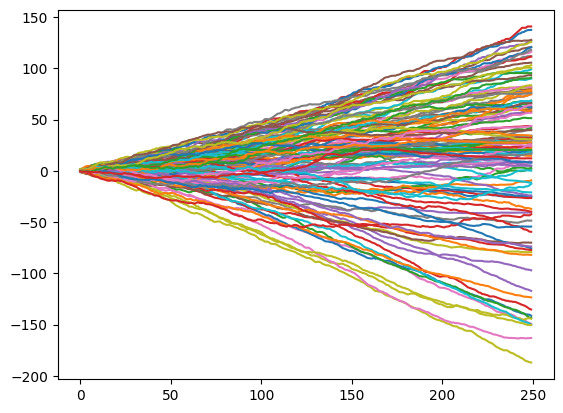

In [11]:
with torch.no_grad():
    for X in tqdm(dataloader):
        if ma: # ma noise is generated for each batch within dataset class
            X, noise = X
            if noise.device != device: noise = noise.to(device)
        else: # Gaussian noise is generated for each batch
            noise = torch.tensor(rng.normal(size=(batch_size, sample_len-1, noise_dim)), device=device, dtype=dtype, requires_grad=False)
        X = X.to(device)

        t = X[:,:,:1] # time dimension of path is always first series of the last dim
        if conditional:
            hist_x = X[:,:hist_len,1:] # history portion of path
            output = generator(noise, t, hist_x=hist_x)
            output = torch.cat([t, output], axis=-1) # concatenate time and history + generated path along time series value dimension
            # remove history portion from X and output to compute MMD only on generated path
            X = X[:,hist_len:,:]
            output = output[:,hist_len:,:]
        else:
            output = generator(noise, t)
            output = torch.cat([t, output], axis=-1) # concatenate time and generated path along time series value dimension

        plt.plot(output[:,:,1].T)
